## OP Learning Agenda: Influence of College Fit Type on Students' Outcomes

### Abstract

One of the key choices in a students' career is what college they attend. To help guide students, College Track has created a set of criteria to categorize schools to better inform students of their chance of success. 

The goal of this learning agenda was to evaluate if students chance of success was influenced by the fit type of school they attended. 

Overall, Fit Type is a moderately good indicator of students graduation rate, however, it still lags heavily behind GPA as the best predictors. Of note, it is more predictive than any income, ethnic, or first-generation status. 

For this project, students were broken up into different categories based on their GPA to see if fit type had a bigger influence on students in certain GPA ranges. Students were only divided based on GPA as ethnicity, income, and first-generation status didn't have a strong predictor and would only limit the sample sizes. 

For students with GPAs above 2.75, most fit types had no statistically significant influence on their likelihood to graduate. The only exception was attending a local affordable school did have a small negative influence on graduation success. 

For students below a 2.75 GPA, only attending a best fit school had a positive influence on graduation success, and all other fit types had a statistically significant negative impact. This positive relationship with attending a best fit school applies to all students below a 2.75 GPA that we have enough data on. 

Of note there, is attending a good fit, local affordable, or no fit type school has a negative impact on graduation success. In particular, attending a local affordable school deceased your chances of graduation by roughly half. 

One artifact of this analysis is the possibility that the specific school a student attends has a very high predictor of graduation success. Unfortunately, we do not yet have enough data on graduation rates from individual schools to fully explore this possibility, but it does open the door to reevaluating how we determine schools' fit types. 

In [54]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import statsmodels.api as sm
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dython.nominal import correlation_ratio, associations

import statsmodels.formula.api as smf
import statsmodels.api as sm


In [4]:
%matplotlib inline

In [5]:
today = datetime.today()
in_file = Path.cwd() / "data" / "processed" / "processed_data.pkl"
report_dir = Path.cwd() / "reports"
report_file = report_dir / "Excel_Analysis_{today:%b-%d-%Y}.xlsx"

in_file2 = Path.cwd() / "data" / "processed" / "processed_data_file2.pkl"

in_file3 = Path.cwd() / "data" / "processed" / "processed_data_file3.pkl"


In [6]:
df = pd.read_pickle(in_file)

df2 = pd.read_pickle(in_file2)

# df3 = pd.read_pickle(in_file3)

In [7]:
# Because some data points are limited for historical classes,
# setting up data frames to deal with various historical limitations 

df_matriculation_data = df[df.high_school_class >= 2015]

df_4_year_grades = df[df.high_school_class <= 2015]
df_5_year_grades = df[df.high_school_class <= 2014]
df_6_year_grades = df[df.high_school_class <= 2013]

In [45]:
df_5_year_grades_above_3_gpa = df_5_year_grades[df_5_year_grades.year_1 >= 3]

df_5_year_grades_below_3_gpa = df_5_year_grades[df_5_year_grades.year_1 < 3]

df_5_year_grades_below_275_gpa = df_5_year_grades[df_5_year_grades.year_1 <= 2.75]

df_grades_below_275 = df[df.year_1 <= 2.75]
df_grades_above_3_gpa = df[df.year_1 > 3]

## General Distributions

#### Table 1. 5 Year Graduation Rate by Fit Type

In [21]:
grad_rate_5_year = pd.crosstab(df_5_year_grades.updated_fit_type,
            df_5_year_grades.graduated_4_year_degree_less_5_years, normalize='index', margins=True)

grad_rate_5_year.round(2).style.format('{:.0%}')

graduated_4_year_degree_less_5_years,False,True
updated_fit_type,,
Best Fit,21%,79%
Good Fit,67%,33%
Local Affordable,66%,34%
None,81%,19%
All,55%,45%


#### Table 2. 5 Year Graduation Rate by Fit Type - Students Below 2.75 GPA in Year 1

In [39]:
grad_rate_5_year = pd.crosstab(df_5_year_grades_below_275_gpa.updated_fit_type,
            df_5_year_grades_below_275_gpa.graduated_4_year_degree_less_5_years, normalize='index', margins=True)

grad_rate_5_year.round(2).style.format('{:.0%}')

graduated_4_year_degree_less_5_years,False,True
updated_fit_type,,
Best Fit,31%,69%
Good Fit,82%,18%
Local Affordable,78%,22%
None,86%,14%
All,70%,30%


#### Table 3. 5 Year Graduation Rate by Fit Type - Students Below 3.0 GPA in Year 1

In [38]:
grad_rate_5_year = pd.crosstab(df_5_year_grades_above_3_gpa.updated_fit_type,
            df_5_year_grades_above_3_gpa.graduated_4_year_degree_less_5_years, normalize='index', margins=True)

grad_rate_5_year.round(2).style.format('{:.0%}')

graduated_4_year_degree_less_5_years,False,True
updated_fit_type,,
Best Fit,10%,90%
Good Fit,26%,74%
Local Affordable,47%,53%
None,30%,70%
All,23%,77%


#### Table 4. Persistence Rate by Fit Type

In [40]:
pd.crosstab(df.updated_fit_type, df.indicator_persisted_into_year_2_ct,
            normalize='index').round(2).style.format('{:.0%}')

indicator_persisted_into_year_2_ct,False,True
updated_fit_type,,
Best Fit,6%,94%
Good Fit,23%,77%
Local Affordable,13%,87%
None,34%,66%


#### Table 5. Persistence Rate by Fit Type - Students Below 2.75 GPA in Year 1 

In [42]:
pd.crosstab(df_grades_below_275.updated_fit_type, df_grades_below_275.indicator_persisted_into_year_2_ct,
            normalize='index').round(2).style.format('{:.0%}')

indicator_persisted_into_year_2_ct,False,True
updated_fit_type,,
Best Fit,11%,89%
Good Fit,35%,65%
Local Affordable,19%,81%
None,42%,58%


#### Table 6. Fit Type Breakdown by High School Class

In [43]:
pd.crosstab(df.high_school_class, df.updated_fit_type, normalize='index').round(2).style.format('{:.0%}')

updated_fit_type,Best Fit,Good Fit,Local Affordable,None
high_school_class,,,,
2011,40%,30%,10%,21%
2012,31%,28%,12%,28%
2013,26%,38%,12%,23%
2014,37%,18%,15%,30%
2015,33%,27%,18%,22%
2016,36%,25%,14%,25%
2017,39%,8%,17%,37%
2018,47%,5%,20%,29%


#### Table 7. Fit Type Breakdown by High School Class - Students Below 2.75 in Year 1 

In [49]:
pd.crosstab(df_grades_below_275.high_school_class, df_grades_below_275.updated_fit_type, normalize='index').round(2).style.format('{:.0%}')

updated_fit_type,Best Fit,Good Fit,Local Affordable,None
high_school_class,,,,
2011,20%,40%,20%,20%
2012,16%,30%,11%,43%
2013,23%,28%,17%,32%
2014,35%,7%,14%,45%
2015,27%,30%,15%,28%
2016,30%,27%,13%,29%
2017,31%,10%,15%,45%
2018,44%,6%,22%,28%


#### Table 8. Fit Type Breakdown by High School Class - Students Above 3.0 in Year 1 


In [48]:
pd.crosstab(df_grades_above_3_gpa.high_school_class, df_grades_above_3_gpa.updated_fit_type, normalize='index').round(2).style.format('{:.0%}')

updated_fit_type,Best Fit,Good Fit,Local Affordable,None
high_school_class,,,,
2011,67%,22%,11%,0%
2012,50%,11%,39%,0%
2013,38%,43%,10%,10%
2014,46%,24%,18%,12%
2015,41%,19%,25%,15%
2016,47%,21%,17%,15%
2017,55%,7%,15%,22%
2018,48%,2%,21%,29%


## Correlation Coefficients

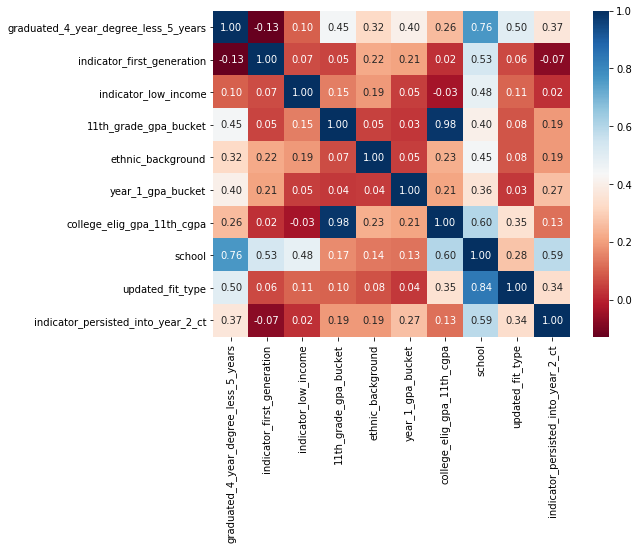

In [60]:
associations(df_5_year_grades[
    ['graduated_4_year_degree_less_5_years', 'indicator_first_generation',
     'indicator_low_income', '11th_grade_gpa_bucket', 'ethnic_background',
     'year_1_gpa_bucket', 'college_elig_gpa_11th_cgpa',
     'school', 'updated_fit_type', 'indicator_persisted_into_year_2_ct']
], theil_u=True, cmap="RdBu", figsize=(8, 6))

## Regressions

In [61]:
def C1(cat):
     return pd.get_dummies(cat, drop_first=True)

#### Regression 1. 5 Year Graduation Rate - All Eligible Students

Note: The significant p value for Best Fit and Local Affordable schools - best fit with the positive coefficient and local affordable with the negative coefficient. 

In [67]:
mod = smf.logit(formula= "C1(graduated_4_year_degree_less_5_years) ~ year_1  + Q('11th_grade') + C(indicator_first_generation, Treatment) + C(updated_fit_type, Sum) + C(indicator_low_income) + C(indicator_persisted_into_year_2_ct)", data=df_5_year_grades).fit(method='bfgs', maxiter=100)
mod.summary()

Optimization terminated successfully.
         Current function value: 0.401899
         Iterations: 48
         Function evaluations: 50
         Gradient evaluations: 50


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      Logit Regression Results                                      
====================================================================================================
Dep. Variable:     C1(graduated_4_year_degree_less_5_years)   No. Observations:                  306
Model:                                                Logit   Df Residuals:                      297
Method:                                                 MLE   Df Model:                            8
Date:                                      Fri, 27 Mar 2020   Pseudo R-squ.:                  0.4201
Time:                                              14:50:50   Log-Likelihood:                -122.98
converged:                                             True   LL-Null:                       -212.08
Covariance Type:                                  nonrobust   LLR p-value:                 2.468e-34
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -8.3987      1.339     -6.271      0.000     -11.024      -5.774
C(indicator_first_generation, Treatment)[T.True]    -0.7130      0.423     -1.687      0.092      -1.541       0.115
C(updated_fit_type, Sum)[S.Best Fit]                 1.1054      0.283      3.905      0.000       0.551       1.660
C(updated_fit_type, Sum)[S.Good Fit]                -0.0673      0.286     -0.236      0.814      -0.628       0.493
C(updated_fit_type, Sum)[S.Local Affordable]        -0.8548      0.323     -2.646      0.008      -1.488      -0.222
C(indicator_low_income)[T.True]                      0.4225      0.470      0.899      0.369      -0.499       1.344
C(indicator_persisted_into_year_2_ct)[T.True]        1.2663      0.649      1.953      0.051      -0.005       2.537
year_1                                               1.8093      0.313      5.777      0.000       1.195       2.423
Q('11th_grade')                                      0.8616      0.308      2.797      0.005       0.258       1.465
====================================================================================================================
"""

#### Regression 2. 5 Year Graduation Rate - Students above 3.0 GPA

Note, none of the fit types are statistically significant

In [68]:
mod = smf.logit(formula= "C1(graduated_4_year_degree_less_5_years) ~ year_1  + Q('11th_grade') + C(indicator_first_generation, Treatment) + C(updated_fit_type, Sum) + C(indicator_low_income) + C(indicator_persisted_into_year_2_ct)", data=df_5_year_grades_above_3_gpa).fit(method='bfgs', maxiter=100)
mod.summary()

Optimization terminated successfully.
         Current function value: 0.402441
         Iterations: 62
         Function evaluations: 64
         Gradient evaluations: 64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      Logit Regression Results                                      
====================================================================================================
Dep. Variable:     C1(graduated_4_year_degree_less_5_years)   No. Observations:                   98
Model:                                                Logit   Df Residuals:                       89
Method:                                                 MLE   Df Model:                            8
Date:                                      Fri, 27 Mar 2020   Pseudo R-squ.:                  0.2770
Time:                                              14:51:19   Log-Likelihood:                -39.439
converged:                                             True   LL-Null:                       -54.553
Covariance Type:                                  nonrobust   LLR p-value:                 0.0001927
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          -10.4274      4.354     -2.395      0.017     -18.960      -1.895
C(indicator_first_generation, Treatment)[T.True]    -1.8068      0.930     -1.943      0.052      -3.629       0.015
C(updated_fit_type, Sum)[S.Best Fit]                 0.5965      0.510      1.169      0.242      -0.403       1.596
C(updated_fit_type, Sum)[S.Good Fit]                 0.5496      0.507      1.084      0.278      -0.444       1.543
C(updated_fit_type, Sum)[S.Local Affordable]        -0.4484      0.540     -0.830      0.407      -1.508       0.611
C(indicator_low_income)[T.True]                      0.0042      0.886      0.005      0.996      -1.733       1.741
C(indicator_persisted_into_year_2_ct)[T.True]        0.7159      1.124      0.637      0.524      -1.487       2.919
year_1                                               2.1566      1.387      1.555      0.120      -0.562       4.875
Q('11th_grade')                                      1.5778      0.658      2.399      0.016       0.289       2.867
====================================================================================================================
"""

#### Regression 3. 5 Year Graduation Rate - Students below 2.75 GPA

Note, once again only best and local affordable are statistically significant. 


In [72]:
mod = smf.logit(formula= "C1(graduated_4_year_degree_less_5_years) ~ year_1  + Q('11th_grade') + C(indicator_first_generation, Treatment) + C(updated_fit_type, Sum) + C(indicator_low_income) + C(indicator_persisted_into_year_2_ct)", data=df_5_year_grades_below_275_gpa).fit(method='bfgs', maxiter=100)
mod.summary()

Optimization terminated successfully.
         Current function value: 0.350699
         Iterations: 59
         Function evaluations: 61
         Gradient evaluations: 61


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      Logit Regression Results                                      
====================================================================================================
Dep. Variable:     C1(graduated_4_year_degree_less_5_years)   No. Observations:                  172
Model:                                                Logit   Df Residuals:                      163
Method:                                                 MLE   Df Model:                            8
Date:                                      Fri, 27 Mar 2020   Pseudo R-squ.:                  0.4182
Time:                                              14:55:51   Log-Likelihood:                -60.320
converged:                                             True   LL-Null:                       -103.68
Covariance Type:                                  nonrobust   LLR p-value:                 2.156e-15
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                          -10.1592      2.311     -4.396      0.000     -14.689      -5.629
C(indicator_first_generation, Treatment)[T.True]    -0.1559      0.635     -0.245      0.806      -1.401       1.089
C(updated_fit_type, Sum)[S.Best Fit]                 1.4626      0.411      3.562      0.000       0.658       2.267
C(updated_fit_type, Sum)[S.Good Fit]                -0.1613      0.449     -0.359      0.719      -1.041       0.719
C(updated_fit_type, Sum)[S.Local Affordable]        -1.0241      0.510     -2.009      0.045      -2.023      -0.025
C(indicator_low_income)[T.True]                      0.3654      0.691      0.529      0.597      -0.988       1.719
C(indicator_persisted_into_year_2_ct)[T.True]        1.2089      0.851      1.421      0.155      -0.459       2.877
year_1                                               2.6218      0.680      3.855      0.000       1.289       3.955
Q('11th_grade')                                      0.7234      0.425      1.704      0.088      -0.109       1.556
====================================================================================================================
"""

##### Odds Ratio for Previous Regression



In [73]:
np.exp(mod.params)

Intercept                                            0.000039
C(indicator_first_generation, Treatment)[T.True]     0.855637
C(updated_fit_type, Sum)[S.Best Fit]                 4.317135
C(updated_fit_type, Sum)[S.Good Fit]                 0.851010
C(updated_fit_type, Sum)[S.Local Affordable]         0.359106
C(indicator_low_income)[T.True]                      1.441070
C(indicator_persisted_into_year_2_ct)[T.True]        3.349807
year_1                                              13.760624
Q('11th_grade')                                      2.061512
dtype: float64

In [66]:


%%html

<script>
$(document).ready(function(){
    window.code_toggle = function() {
        (window.code_shown) ? $('div.input').hide(250) : $('div.input').show(250);
        window.code_shown = !window.code_shown
    }
    if($('body.nbviewer').length) {
        $('<li><a href="javascript:window.code_toggle()" title="Show/Hide Code"><span class="fa fa-code fa-2x menu-icon"></span><span class="menu-text">Show/Hide Code</span></a></li>').appendTo('.navbar-right');
        window.code_shown=false;
        $('div.input').hide();
    }
});
</script>


<style>

// div.prompt {display:none}


h1, .h1 {
    font-size: 33px;
    font-family: "Trebuchet MS";
    font-size: 2.5em !important;
    color: #2a7bbd;
}

h2, .h2 {
    font-size: 10px;
    font-family: "Trebuchet MS";
    color: #2a7bbd; 
    
}


h3, .h3 {
    font-size: 10px;
    font-family: "Trebuchet MS";
    color: #5d6063; 
    
}

.rendered_html table {

    font-size: 14px;
}

.output_png {
  display: flex;
  justify-content: center;
}

.cell {
    padding: 0px;
}


</style>